In [34]:
print('Riddh Modi.')

Riddh Modi.


In [35]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [36]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 20
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "PlantVillage"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [37]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 382 files belonging to 3 classes.


In [39]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


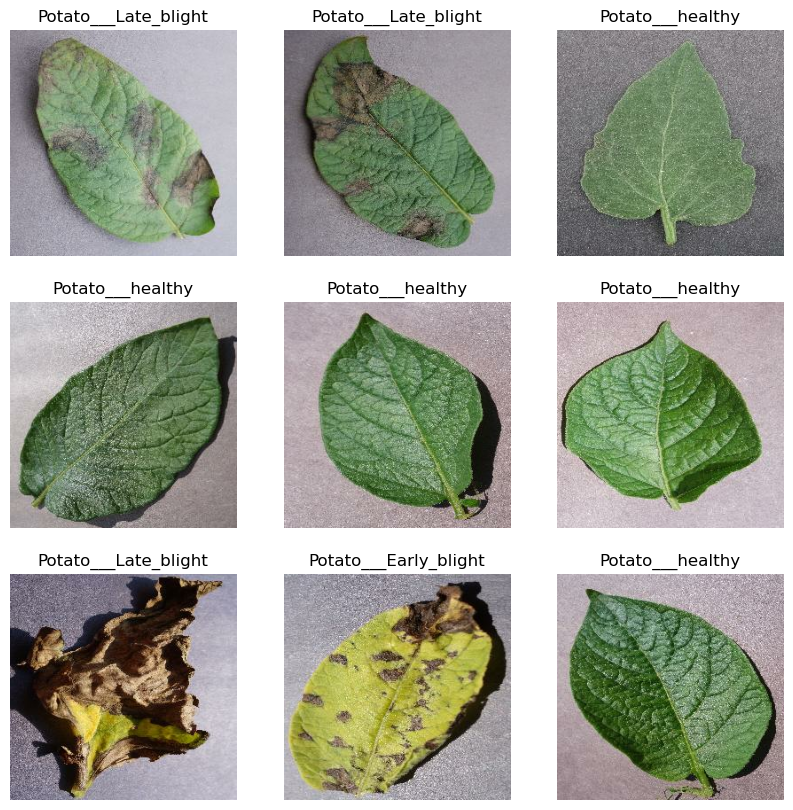

In [40]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [44]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [45]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [46]:

# model = models.Sequential([
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),   
# ])
# model.build(input_shape=batch_input_shape)


In [47]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [49]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
9/9 [==============================] - 53s 4s/step - loss: 1.0930 - accuracy: 0.3741 - val_loss: 1.0884 - val_accuracy: 0.3438
Epoch 2/20
9/9 [==============================] - 36s 4s/step - loss: 1.0920 - accuracy: 0.3846 - val_loss: 1.0864 - val_accuracy: 0.3438
Epoch 3/20
9/9 [==============================] - 37s 4s/step - loss: 1.0917 - accuracy: 0.3951 - val_loss: 1.0914 - val_accuracy: 0.3438
Epoch 4/20
9/9 [==============================] - 36s 4s/step - loss: 1.0928 - accuracy: 0.3427 - val_loss: 1.0815 - val_accuracy: 0.3438
Epoch 5/20
9/9 [==============================] - 37s 4s/step - loss: 1.0957 - accuracy: 0.3741 - val_loss: 1.0916 - val_accuracy: 0.3438
Epoch 6/20
9/9 [==============================] - 35s 4s/step - loss: 1.0899 - accuracy: 0.3951 - val_loss: 1.0978 - val_accuracy: 0.3438
Epoch 7/20
9/9 [==============================] - 36s 4s/step - loss: 1.0834 - accuracy: 0.3951 - val_loss: 1.0862 - val_accuracy: 0.3438
Epoch 8/20
9/9 [==================

In [50]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
2/2 [==============================] - 3s 839ms/step - loss: 0.7093 - accuracy: 0.7344
Test Accuracy: 73.44000000000001%


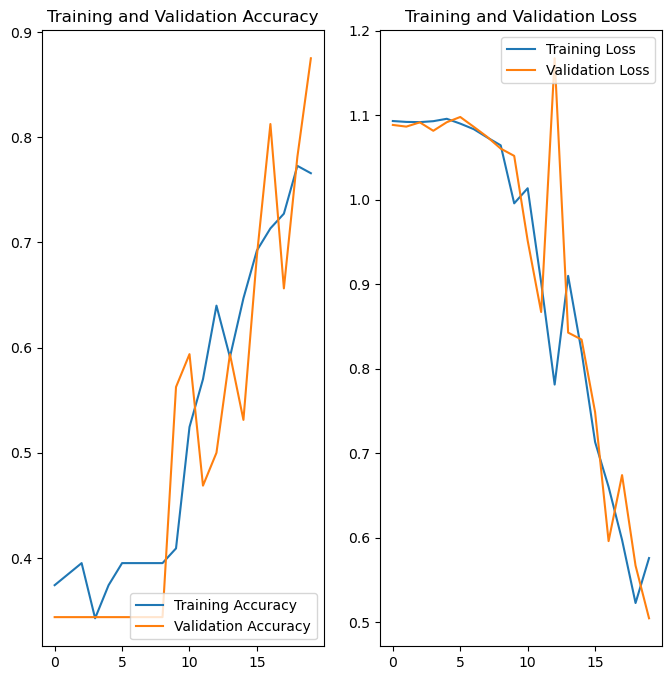

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
import os
model_version = max([int(i) for i in (os.listdir("models")+[0])]) + 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/10\assets


INFO:tensorflow:Assets written to: models/10\assets


In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 98ms/step


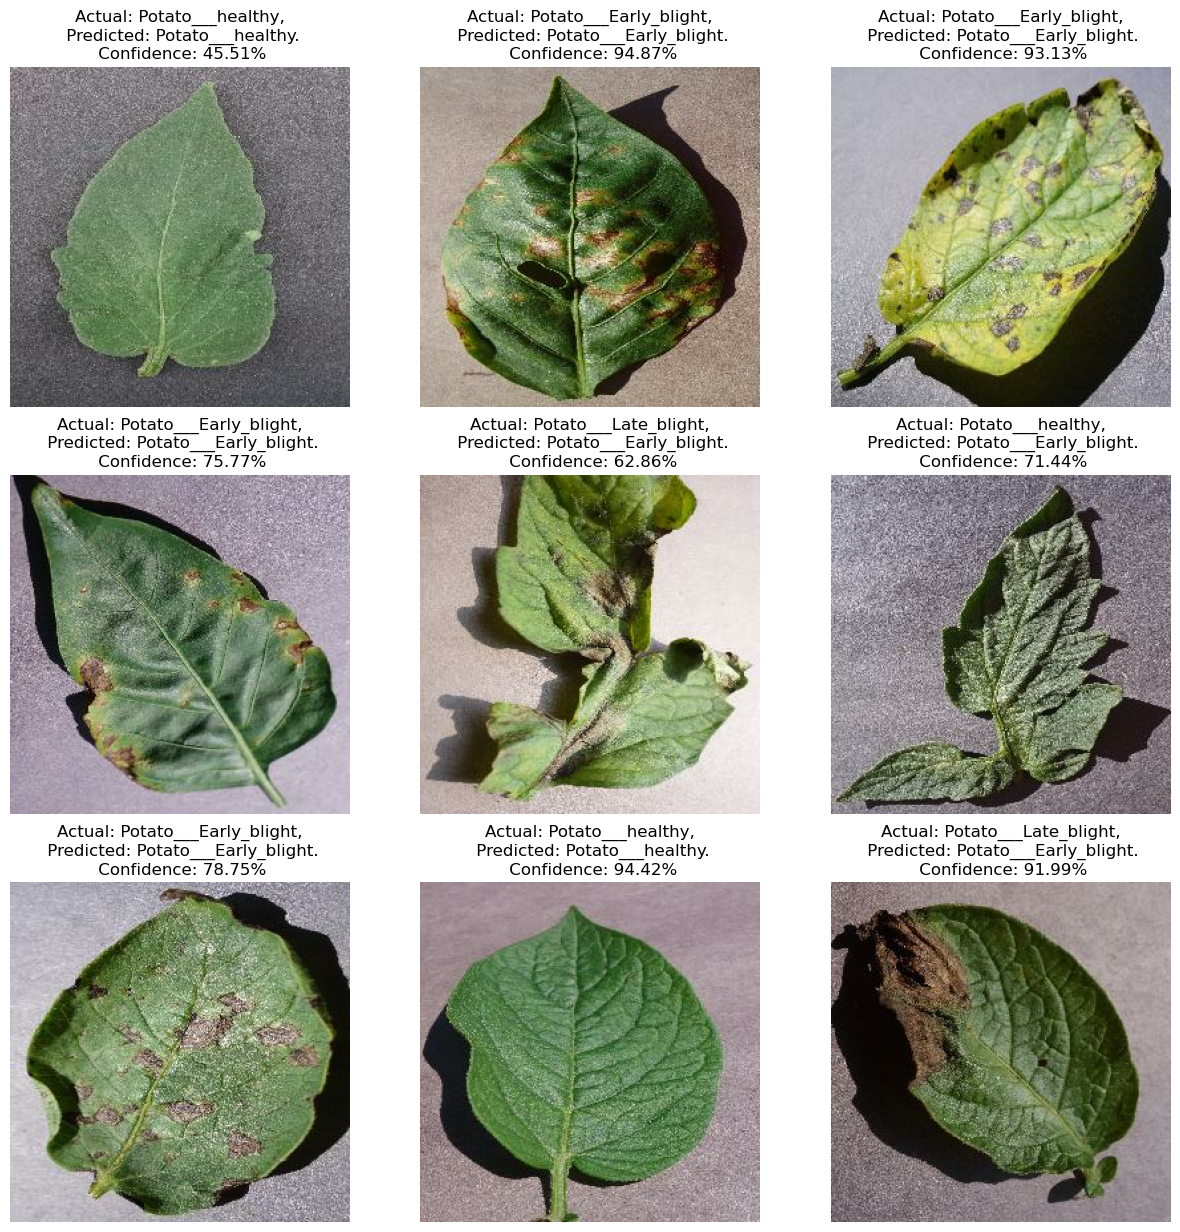

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [55]:
BATCH_SIZE

32

In [56]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)         

In [58]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [59]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
9/9 [==============================] - 50s 4s/step - loss: 1.1086 - accuracy: 0.3741 - val_loss: 1.0835 - val_accuracy: 0.4062
Epoch 2/20
9/9 [==============================] - 36s 4s/step - loss: 1.0918 - accuracy: 0.3741 - val_loss: 1.0810 - val_accuracy: 0.3438
Epoch 3/20
9/9 [==============================] - 21s 2s/step - loss: 1.0880 - accuracy: 0.3951 - val_loss: 1.0866 - val_accuracy: 0.3438
Epoch 4/20
9/9 [==============================] - 19s 2s/step - loss: 1.0816 - accuracy: 0.3951 - val_loss: 1.0614 - val_accuracy: 0.3438
Epoch 5/20
9/9 [==============================] - 19s 2s/step - loss: 1.0658 - accuracy: 0.4580 - val_loss: 1.0257 - val_accuracy: 0.4375
Epoch 6/20
9/9 [==============================] - 19s 2s/step - loss: 1.0137 - accuracy: 0.5070 - val_loss: 0.9737 - val_accuracy: 0.5000
Epoch 7/20
9/9 [==============================] - 19s 2s/step - loss: 0.8890 - accuracy: 0.5944 - val_loss: 0.8020 - val_accuracy: 0.6250
Epoch 8/20
9/9 [==================

In [60]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 549ms/step - loss: 0.3174 - accuracy: 0.8438


In [61]:
scores

[0.3173914849758148, 0.84375]

In [62]:
history

In [63]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 9}

In [64]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
type(history.history['loss'])

list

In [66]:
len(history.history['loss'])

20

In [67]:
history.history['loss'][:5] 

[1.1086167097091675,
 1.0918309688568115,
 1.0880398750305176,
 1.0815722942352295,
 1.0657974481582642]

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

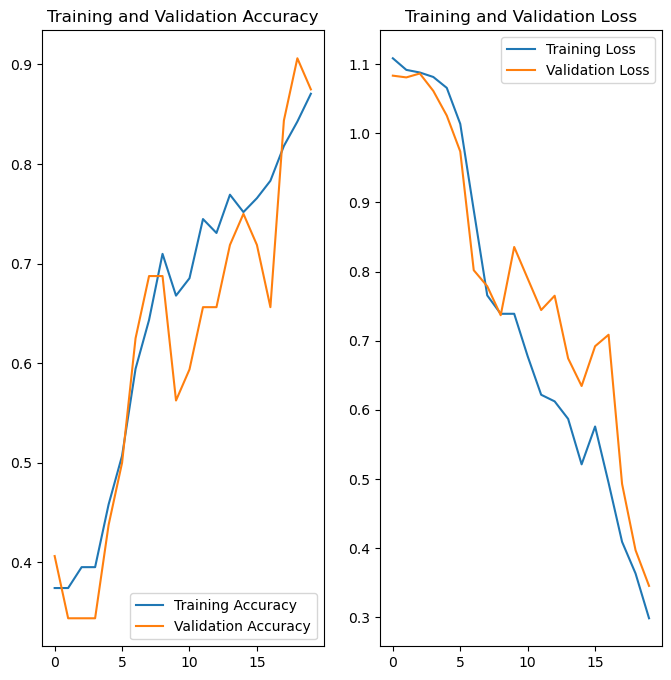

In [69]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 1s 742ms/step
predicted label: Potato___healthy


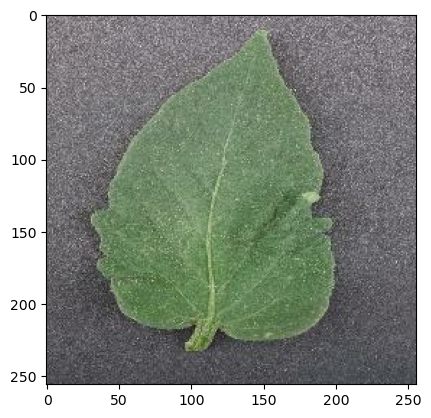

In [70]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [71]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


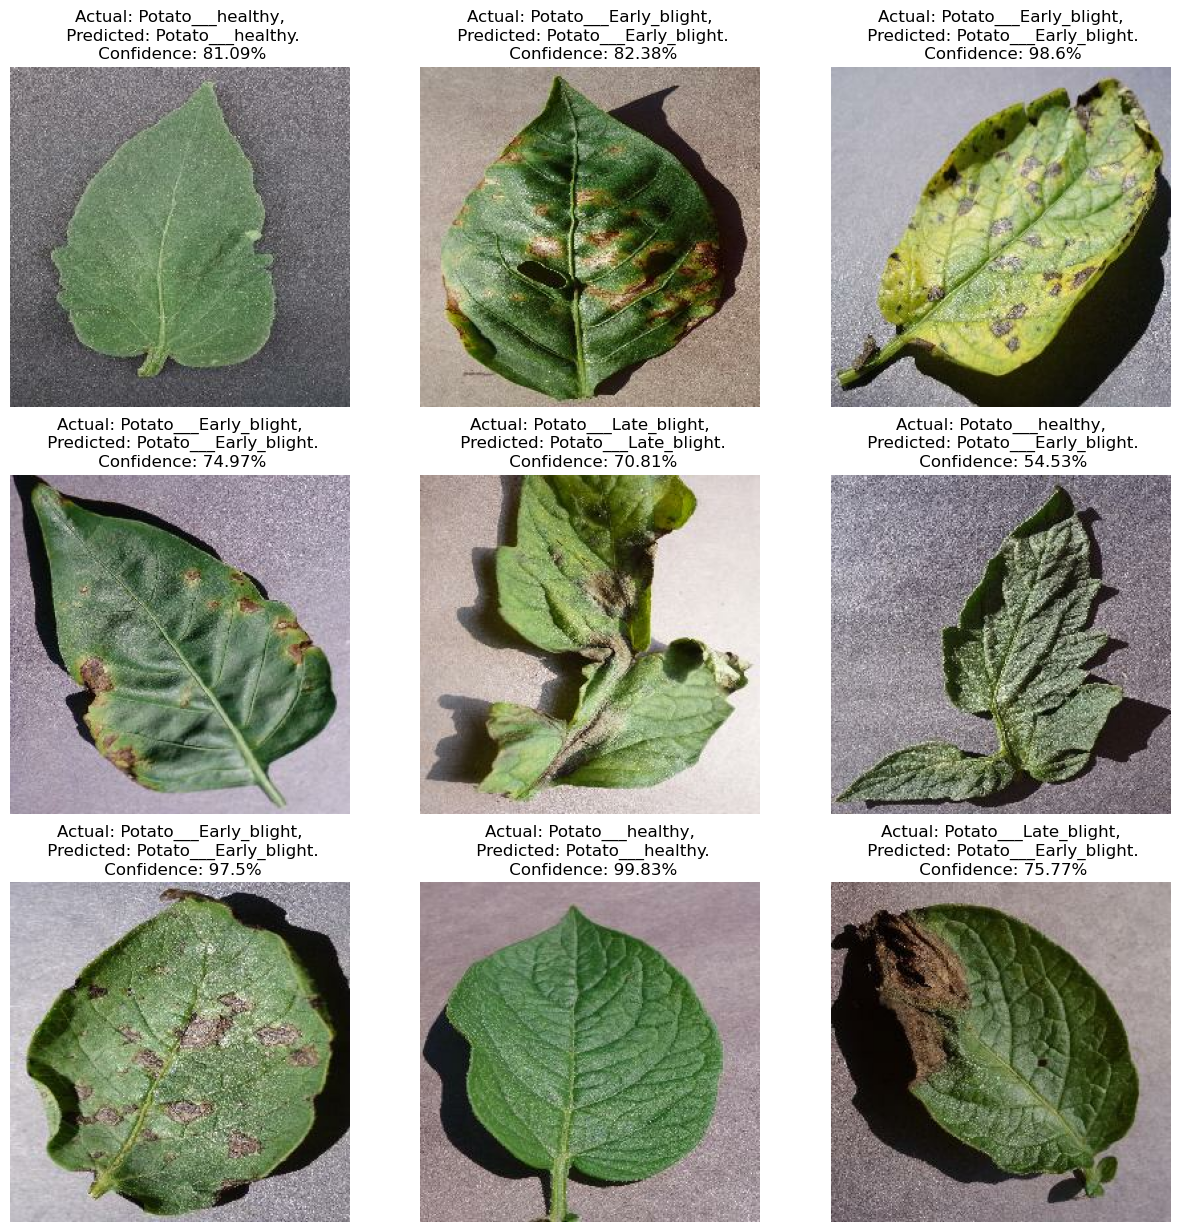

In [72]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [77]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/13\assets


INFO:tensorflow:Assets written to: models/13\assets


In [78]:
model.save("potatoes.h5")

C:\Users\Riddh Modi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
